In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display

MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'


In [2]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred


#Read training, validation and test data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/CourseWork/ENEE719D/Dataset'
data_train=sio.loadmat(PATH + '/commands_train.mat') #Change this to point to your dataset
Input_train=data_train['Input_train']
Input_train=np.reshape(Input_train,[Input_train.shape[0],1,Input_train.shape[1],1])
Label_train=data_train['Label_train']

data_val=sio.loadmat(PATH + '/commands_val.mat') #Change this to point to your dataset
Input_val=data_val['Input_val']
Input_val=np.reshape(Input_val,[Input_val.shape[0],1,Input_val.shape[1],1])
Label_val=data_val['Label_val']


data_test=sio.loadmat(PATH + '/commands_test.mat') #Change this to point to your dataset
Input_test=data_test['Input_test']
Input_test=np.reshape(Input_test,[Input_test.shape[0],1,Input_test.shape[1],1])
Label_test=data_test['Label_test']

Label_train= tf.keras.utils.to_categorical(Label_train)
Label_val= tf.keras.utils.to_categorical(Label_val)


#Create a model

Fit the model

#Hyperparameter tunning

In [81]:
def build_model(hp):
  model = tf.keras.Sequential()
  hp_units_1 = hp.Choice('f1', [8, 12, 15])
  hp_units_2 = hp.Choice('f2', [5, 10, 15])
  hp_units_3 = hp.Choice('ker1', [300, 400, 500])
  hp_units_4 = hp.Choice('str1', [100, 125, 150])
  hp_units_5 = hp.Choice('ker2', [15, 20, 25])
  model.add(layers.Conv2D(filters=hp_units_1,kernel_size=(1, hp_units_3), strides=(1, hp_units_4),activation='relu', input_shape=(1,16000,1)))
  # model.add(layers.MaxPooling2D(pool_size=[1,2]))
  # model.add(keras.layers.Dropout(0.001,  seed=10 ))
  model.add(layers.MaxPooling2D(pool_size=[1,2]))
  model.add(layers.Conv2D(filters=hp_units_2,kernel_size=[1,hp_units_5],activation='relu'))
  # model.add(keras.layers.Dropout(0.001,  seed=10 ))
  # model.add(layers.Conv2D(filters=1,kernel_size=[1,25],activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=[1,2]))
  model.add(layers.Flatten())
  model.add(layers.Dense(2,activation='softmax', input_shape=(16000,)))
  # model.add(keras.layers.Dropout(0.005,  seed=10 ))
  #model.add(layers.Dropout(0.25))
  opt = keras.optimizers.Adam(learning_rate=0.01)
  model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy (), metrics=['accuracy'])
  model.summary()
  return model

In [82]:
!pip install keras-tuner --upgrade
import keras_tuner
import keras
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=27,
    directory='models',
    project_name='kt_results_4')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 158, 8)         2408      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 79, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 65, 5)          605       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 32, 5)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 160)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [83]:
callbacks = [EarlyStopping(monitor='val_loss', patience=12) ,ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
tuner.search(Input_train, Label_train, epochs=32, validation_data=(Input_val, Label_val), callbacks=[callbacks])
# best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]





Trial 27 Complete [00h 00m 19s]
val_loss: 0.2639135718345642

Best val_loss So Far: 0.09862727671861649
Total elapsed time: 00h 13m 12s


In [85]:
print("best hp hp_units_1 {} {} {} {} {} ".format(best_hp.get('f1'),
                                         best_hp.get('f2'),
                                         best_hp.get('ker1'),
                                         best_hp.get('ker2'),
                                         best_hp.get('str1')))

best hp hp_units_1 8 5 400 25 150 


In [7]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=best_hp.get('f1'),kernel_size=[1,best_hp.get('ker1')],strides=(1, best_hp.get('str1')),activation='relu', input_shape=(1,16000,1)))
model.add(layers.MaxPooling2D(pool_size=[1,2]))
# model.add(keras.layers.Dropout(0.001,  seed=10 ))
model.add(layers.Conv2D(filters=best_hp.get('f2'),kernel_size=[1,best_hp.get('ker2')],activation='relu'))
# model.add(keras.layers.Dropout(0.001,  seed=10 ))
# model.add(layers.Conv2D(filters=1,kernel_size=[1,25],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))
model.add(layers.Flatten())
model.add(layers.Dense(2,activation='softmax', input_shape=(16000,)))
# model.add(keras.layers.Dropout(0.005,  seed=10 ))
#model.add(layers.Dropout(0.25))
model.summary()

NameError: name 'best_hp' is not defined

# Model Learning

In [10]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=8,kernel_size=[1,400],strides=(1, 150),activation='relu', input_shape=(1,16000,1)))
model.add(layers.MaxPooling2D(pool_size=[1,2]))
# model.add(keras.layers.Dropout(0.001,  seed=10 ))
model.add(layers.Conv2D(filters=8,kernel_size=[1,25],activation='relu'))
# model.add(keras.layers.Dropout(0.001,  seed=10 ))
# model.add(layers.Conv2D(filters=1,kernel_size=[1,25],activation='relu'))
model.add(layers.MaxPooling2D(pool_size=[1,2]))
model.add(layers.Flatten())
model.add(layers.Dense(2,activation='softmax', input_shape=(16000,)))
# model.add(keras.layers.Dropout(0.005,  seed=10 ))
#model.add(layers.Dropout(0.25))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 1, 105, 8)         3208      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 1, 52, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 28, 8)          1608      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 1, 14, 8)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 112)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                

In [ ]:
# model = tf.keras.Sequential()
# model.add(layers.Conv2D(filters=16,kernel_size=[1,500],strides=(1, 125),activation='relu', input_shape=(1,16000,1)))
# # model.add(layers.MaxPooling2D(pool_size=[1,2]))
# # model.add(keras.layers.Dropout(0.001,  seed=10 ))
# model.add(layers.Conv2D(filters=15,kernel_size=[1,50],activation='relu'))
# # model.add(keras.layers.Dropout(50.001,  seed=10 ))
# # model.add(layers.Conv2D(filters=1,kernel_size=[1,25],activation='relu'))
# model.add(layers.MaxPooling2D(pool_size=[1,2]))
# model.add(layers.Flatten())
# model.add(layers.Dense(2,activation='softmax', input_shape=(16000,)))
# # model.add(keras.layers.Dropout(0.005,  seed=10 ))
# #model.add(layers.Dropout(0.25))
# model.summary()

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy (), metrics=['accuracy'])

EPOCHS =1000
callbacks = [EarlyStopping(monitor='val_loss', patience=12), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(Input_train,Label_train,validation_data=(Input_val,Label_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)


##inclass

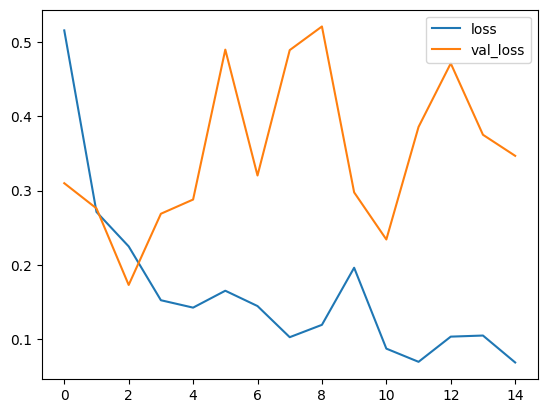

In [12]:

model = load_model('./best_model.h5')
model.save('/content/drive/MyDrive/Dataset/Command_Words/best_model.h5')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Check test accuracy

In [101]:
model=load_model('/content/drive/MyDrive/Dataset/Command_Words/best_model.h5')
model.save(MODEL_TF)
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy is:')
print(f"{test_acc:.2%}")


13/13 [==============================] - 0s 2ms/step
Test accuracy is:
97.01%


<ipython-input-101-54796adbabe6>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))


In [102]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 105, 8)         3208      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 1, 52, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 28, 8)          1608      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 14, 8)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 112)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                

In [103]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(500):
    yield([Input_train[i,:,:,:].reshape(1,1,16000,1).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)



9016

In [104]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true) / len(y_true))
print('Test accuracy with model:')
print(f"{test_acc:.2%}")
y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])
# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite, Input_test[i:i+1,:,:,:]))

test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")


# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")





y_test_pred_tflite=np.empty([Input_test.shape[0],2])

# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,:]=(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('models/tflite_pred.mat',y_test_tflite)


13/13 [==============================] - 0s 2ms/step
Test accuracy with model:
97.01%


<ipython-input-104-ce0b79f3bb75>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_pred == y_true) / len(y_true))
<ipython-input-104-ce0b79f3bb75>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))


Test accuracy with model tf lite:
97.01%


<ipython-input-104-ce0b79f3bb75>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_acc = float(sum(y_test_pred_tflite == y_true) / len(y_true))


Test accuracy with model quantized:
97.51%


Note depending on the model the quantized version might have higher accuracy.

In [105]:
# Calculate size
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {0} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                          
Model                                                            
TensorFlow Lite            23260 bytes       (reduced by 0 bytes)
TensorFlow Lite Quantized    9016 bytes  (reduced by 14244 bytes)

In [106]:
# Calculate size
size_tflite = os.path.getsize(MODEL_TFLITE)
print(size_tflite)

9016


In [107]:

# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [108]:
import zipfile
import os
from datetime import datetime

# Get current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
# Files or directories to be zipped
files_to_zip = ['/content/models', '/content/drive/MyDrive/Dataset/Command_Words/best_model.h5','/content/drive/MyDrive/Colab Notebooks/Command_Word.ipynb']

# Path to save the zip file
zip_file_path = '/content/download_model_{}_{}.zip'.format(test_acc, timestamp)

# Create a zip archive
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for file in files_to_zip:
        if os.path.isdir(file):
            # If it's a directory, add its contents recursively
            for root, dirs, files in os.walk(file):
                for f in files:
                    zipf.write(os.path.join(root, f), arcname=os.path.relpath(os.path.join(root, f), os.path.join(file, '..')))
        else:
            zipf.write(file, arcname=os.path.basename(file))